
<center><b>©Content is made available under the CC-BY-NC-ND 4.0 license. Christian Lopez, lopezbec@lafayette.edu<b><center>

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/lopezbec/intro_python_notebooks/blob/master/Model_Evaluation_and_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
         </table>
          <br><br></br> 

# Model Evaluation and Hyperparameter Tuning

---



In this notebook you will learn how to do hyperparameter tuning using Scikit-learn  and Keras. Specifically, you will learn:

- How to do Hyperparameter tuning with Grid Search
- How to do Hyperparameter tuning with Random Search
- How to do Hyperparameter tuning for NN


<br>
Most of the notebooks we are going to be using are inspired from existing notebooks that are available online and are made free for educational purposes. Nonetheless, these notebooks should not be share without prior permission of the instructor. When working in an assignment always remember the [Student Code of Conduct](https://conduct.lafayette.edu/student-handbook/student-code-of-conduct/).

*The following sections were inspired and uses some of the code and text from the books:

- Géron, A. (2019) 2nd Ed. Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. O'Reilly Media, Inc.( ISBN-10: 1491962291) [Chapter 10](https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb)

- VanderPlas, J. (2016). Python data science handbook: Essential tools for working with data. O'Reilly Media ( ISBN-10: 9781491912058 ) [Chapter 5](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.03-Hyperparameters-and-Model-Validation.ipynb)

## 1- Model Validation



In principle, model validation is very simple: after choosing a model and its hyperparameters, we can estimate how effective it is by applying it to some of the  data and comparing the prediction to the known value.

The following sections first show a naive approach to model validation and why it
fails, before exploring the use of holdout sets and cross-validation for more robust
model evaluation.

### 1.1 -Model validation the wrong way



Let's demonstrate the naive approach to validation using the Iris data.
We will start by loading the data:

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

Next we choose a model and hyperparameters. 

First, we'll use a Polynomial Ridge Logistic Regression model with degrees of polynomial=`25`, and $\lambda$=`0.001`.


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

polybig_features = PolynomialFeatures(degree=25, include_bias=False)
std_scaler = StandardScaler()
Ridge_LogR = RidgeClassifier(0.001)

polynomial_LogRegression = Pipeline([
        ("poly_features", polybig_features),
        ("std_scaler", std_scaler),
        ("Ridge_LogR", Ridge_LogR),
    ])

Then we train the model, and use it to predict labels for data we already know:

In [3]:
polynomial_LogRegression.fit(X, y)
y_model = polynomial_LogRegression.predict(X)


Finally, we compute the fraction of correctly labeled points:

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

We see an accuracy score of 1.0, which indicates that 100% of points were correctly labeled by our model!

Lets try another model and hyperparameters. Here we'll use a *K*-neighbors classifier with ``n_neighbors=1``.
This is a very simple and intuitive model that says "the label of an unknown point is the same as the label of its closest training point:"

if you want to know more about *K*-neighbors classifier  look at these [video 1](https://www.youtube.com/watch?v=4HKqjENq9OU) and [video 2](https://www.youtube.com/watch?v=odqIu23OSbs&feature=emb_logo)

We can implement it using [sklearn *K*-neighbors classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [5]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

#we train the model, and use it to predict labels for data we already know:
model.fit(X, y)
y_model = model.predict(X)

#Finally, we compute the fraction of correctly labeled points:
accuracy_score(y, y_model)

1.0

We see an accuracy score of again of 1.0, which indicates that 100% of points were correctly labeled by our model!

But is this truly measuring the expected accuracy? Have we really come upon a model that we expect to be correct 100% of the time?

As you may have gathered, the answer is no.
In fact, this approach contains a fundamental flaw: 

### **it trains and evaluates the model on the same data**.

Furthermore, the nearest neighbor model is an *instance-based* estimator that simply stores the training data, and predicts labels by comparing new data to these stored points: except in contrived cases, it will get 100% accuracy *every time!* Similarly, with a large number Polynomial degrees and low regularization the Logistic Regression will just overfit the data

## 2-  Model validation the right way: Holdout sets



So what can be done?
A better sense of a model's performance can be found using what's known as a *holdout set* (validation set): that is, we hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance.
This splitting can be done using the ``train_test_split`` utility in Scikit-Learn:

In [6]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

In [7]:
polynomial_LogRegression.fit(X1, y1)
y1_model = polynomial_LogRegression.predict(X1)
accuracy_score(y1, y1_model)


1.0

In [8]:
# fit the model on one set of data
polynomial_LogRegression.fit(X1, y1)



#Validation
y2_model = polynomial_LogRegression.predict(X2)

# evaluate the model on the second set of data
accuracy_score(y2, y2_model)



0.92

In [9]:
# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

We see here a more reasonable result:
- The Polynomial Ridge Logistic Regression is about 92% accurate on this validation set
- The nearest-neighbor classifier is about 90% accurate on this validation set.

The hold-out/validations set is similar to unknown data, because the model has not "seen" it before.

## 3- Model validation via K-fold Cross-Validation


#### 3.1- *2-Fold* CV


One disadvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training.
In the above case, half the dataset does not contribute to the training of the model!
This is not optimal, and can cause problems – especially if the initial set of training data is small.

One way to address this is to use *cross-validation*; that is, to do a sequence of fits where each subset of the data is used both as a training set and as a validation set.
Visually, it might look something like this:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-2-fold-CV.png?raw=1)


Here we do two validation trials, alternately using each half of the data as a holdout set.

Using the split data from before and the *K*-neighbors classifier, we could implement it like this:

In [10]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

#### 3.2- *5-Fold* CV

What comes out are two accuracy scores, which we could combine (by, say, taking the mean) to get a better measure of the global model performance.
This particular form of cross-validation is a *two-fold cross-validation*—that is, one in which we have split the data into two sets and used each in turn as a validation set.

We could expand on this idea to use even more trials, and more folds in the data—for example, here is a visual depiction of five-fold cross-validation:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-5-fold-CV.png?raw=1)



Here we split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data.
This would be rather tedious to do by hand, and so we can use Scikit-Learn's ``cross_val_score`` convenience routine to do it succinctly:

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

In [12]:
import numpy as np
print(np.mean(cross_val_score(model, X, y, cv=5)))
print(round(np.var(cross_val_score(model, X, y, cv=5)),4))

0.96
0.0006


#### 3.3- LOOCV

Repeating the validation across different subsets of the data gives us an even better idea of the performance of the algorithm.

Scikit-Learn implements a number of useful cross-validation schemes that are useful in particular situations; these are implemented via iterators in the ``cross_validation`` module.
For example, we might wish to go to the extreme case in which our number of folds is equal to the number of data points: that is, we train on all points but one in each trial.
This type of cross-validation is known as *leave-one-out* cross validation, and can be used as follows:

In [13]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Because we have 150 samples, the leave one out cross-validation yields scores for 150 trials, and the score indicates either successful (1.0) or unsuccessful (0.0) prediction.
Taking the mean of these gives an estimate of the error rate:

In [14]:
print(np.mean(scores))
print((np.var(scores)))

0.96
0.0384


As you can see while both the LOOCV and the 5-fold CV show a similar average model performance, the variance of the model's performance estimate of the LOOCV is greater  than the 5-fold CV.

Other cross-validation schemes can be used similarly.
For a description of what is available in Scikit-Learn, take a look at Scikit-Learn's online [cross-validation documentation](http://scikit-learn.org/stable/modules/cross_validation.html).

## 4- Selecting the Best Model



Now that we've seen the basics of validation and cross-validation, we will go into a little  more depth regarding model selection and selection of hyperparameters.
These issues are some of the most important aspects of the practice of machine learning.

Of core importance is the following question: *if our estimator is underperforming (i.e., overfitting or underfitting), how should we move forward?*
There are several possible answers:

*Underfitting:*
- Use a more complicated/more flexible model
- Gather more data to add features to each sample or directly increase the degree of polynomial

*Overfitting:*
- Use a less complicated/less flexible model/regularize
- Gather more training samples


The answer to this question is often counter-intuitive.
In particular, sometimes using a more complicated model will give worse results, and adding more training samples may not improve your results!
The ability to determine what steps will improve your model is what separates the successful machine learning practitioners from the unsuccessful.

### 4.1 - The Bias-Variance trade-off



Fundamentally, the question of "the best model" is about finding a sweet spot  of a model with low *bias* and *variance*.
Consider the following figure, which presents two regression fits to the same dataset:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-bias-variance.png?raw=1)


It is clear that neither of these models is a particularly good fit to the data, but they fail in different ways.

The model on the left attempts to find a straight-line fit through the data.
Because the data are intrinsically more complicated than a straight line, the straight-line model will never be able to describe this dataset well.
Such a model is said to *underfit* the data: that is, it does not have enough model flexibility to suitably account for all the features in the data; another way of saying this is that the model has high *bias*.

The model on the right attempts to fit a high-order polynomial through the data.
Here the model fit has enough flexibility to nearly perfectly account for the fine features in the data, but even though it very accurately describes the training data, its precise form seems to be more reflective of the particular noise properties of the data rather than the intrinsic properties of whatever process generated that data.
Such a model is said to *overfit* the data: that is, it has so much model flexibility that the model ends up accounting for random errors as well as the underlying data distribution; another way of saying this is that the model has high *variance*.

To look at this in another light, consider what happens if we use these two models to predict the y-value for some new data.
In the following diagrams, the red/lighter points indicate data that is omitted from the training set:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-bias-variance-2.png?raw=1)


The score here is the $R^2$ score, or [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), which measures how well a model performs relative to a simple mean of the target values. $R^2=1$ indicates a perfect match, $R^2=0$ indicates the model does no better than simply taking the mean of the data, and negative values mean even worse models.
From the scores associated with these two models, we can make an observation that holds more generally:

- For high-bias models, the performance of the model on the validation set is similar to the performance on the training set.
- For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.

If we imagine that we have some ability to tune the model complexity, we would expect the training score and validation score to behave as illustrated in the following figure:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-validation-curve.png?raw=1)

The diagram shown here is often called a *validation curve* (very similar to *learning curves* with the exception that the x-axis is a model hyperparameter, not samples), and we see the following essential features:

- The training score is everywhere higher than the validation score. This is generally the case: the model will be a better fit to data it has seen than to data it has not seen.
- For very low model complexity (a high-bias model), the training data is under-fit, which means that the model is a poor predictor both for the training data and for any previously unseen data.
- For very high model complexity (a high-variance model), the training data is over-fit, which means that the model predicts the training data very well, but fails for any previously unseen data.
- For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.

The means of tuning the model complexity varies from model to model; when we discuss individual models in depth in later sections, we will see how each model allows for such tuning.

#### 4.1.2- Validation curves in Scikit-Learn



Let's look at an example of using cross-validation to compute the validation curve for a class of models.
Here we will use a *polynomial regression* model: this is a generalized linear model in which the degree of the polynomial is a tunable parameter.
For example, a degree-1 polynomial fits a straight line to the data; for model parameters $\theta_0$ and $\theta_1$:

$$
y = \theta_0 + \theta_1 x
$$

A degree-3 polynomial fits a cubic curve to the data; for model parameters $\theta_0, \theta_1, \theta_2, \theta_3$:

$$
y = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3
$$

We can generalize this to any number of polynomial features.
In Scikit-Learn, we can implement this with a simple linear regression combined with the polynomial preprocessor.
We will use a *pipeline* to string these operations together as we have done in the pass.

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Now let's create some data to which we will fit our model:

In [16]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

We can now visualize our data, along with polynomial fits of several degrees:

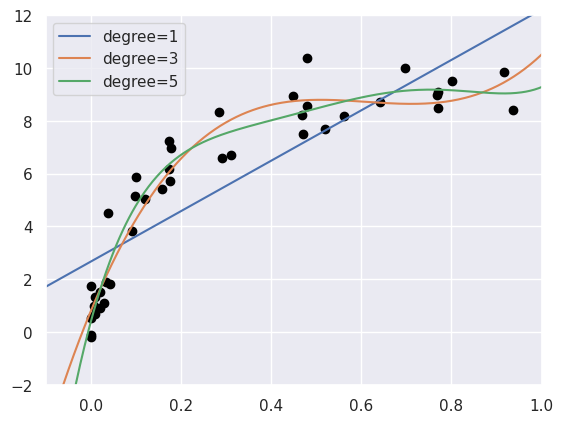

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

The knob controlling model complexity in this case is the degree of the polynomial, which can be any non-negative integer.
A useful question to answer is this: what degree of polynomial provides a suitable trade-off between bias (under-fitting) and variance (over-fitting)?

We can make progress in this by visualizing the validation curve for this particular data and model; this can be done straightforwardly using the ``validation_curve`` convenience routine provided by Scikit-Learn.
Given a model, data, parameter name, and a range to explore, this function will automatically compute both the training score and validation score across the range. In this case the score is the $R^2$ but it can be change to [other metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) :

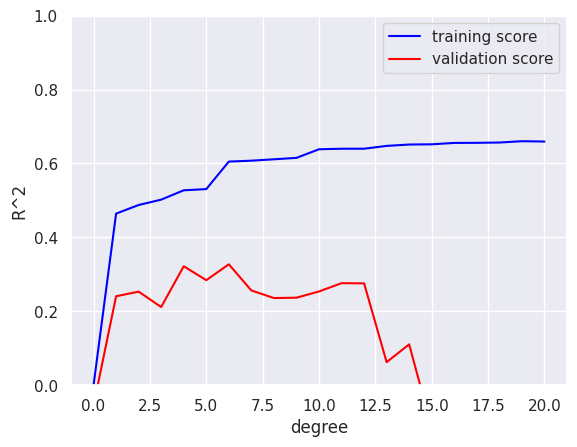

In [18]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 4
    y = 10 - 1. / (X.ravel() + 0.3)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(80)


from sklearn.model_selection import validation_curve
from sklearn.metrics import r2_score
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          param_name='polynomialfeatures__degree', 
                                          param_range=degree, cv=7, scoring="r2")



plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)

plt.xlabel('degree')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.ylabel('R^2');

This shows precisely the qualitative behavior we expect: the training score is everywhere higher than the validation score; the training score is monotonically improving with increased model complexity; and the validation score reaches a maximum before dropping off as the model becomes over-fit.

From the validation curve, we can read-off that the optimal trade-off between bias and variance is found for a third-order polynomial; we can compute and display this fit over the original data as follows:

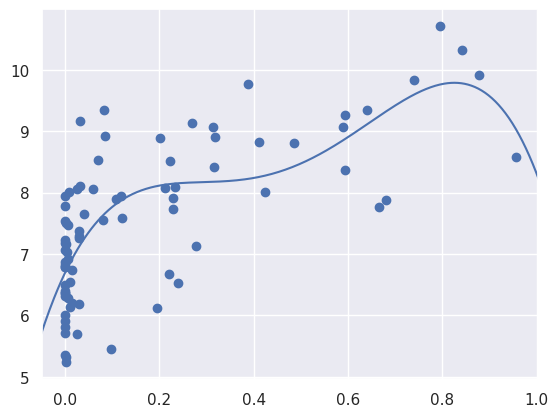

In [19]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(4).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

Notice that finding this optimal model did not actually require us to compute the training score, but examining the relationship between the training score and validation score can give us useful insight into the performance of the model.

#### 4.1.3- Learning Curves



One important aspect of model complexity is that the optimal model will generally depend on the size of your training data.
For example, let's generate a new dataset with a factor of five more points:

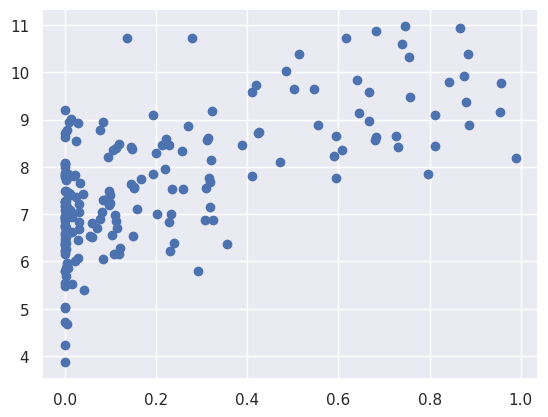

In [20]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

We will duplicate the preceding code to plot the validation curve for this larger dataset; for reference let's over-plot the previous results as well:

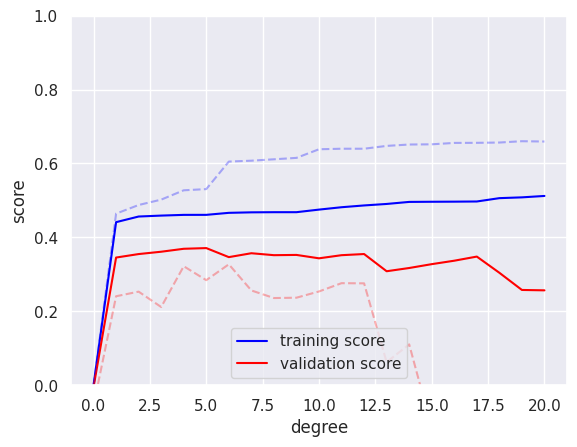

In [21]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            param_name='polynomialfeatures__degree', 
                                            param_range=degree, cv=7)


plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

The solid lines show the new results, while the fainter dashed lines show the results of the previous smaller dataset.
It is clear from the validation curve that the larger dataset can support a much more complicated model: the peak here is probably around a degree of 5, but even a degree-20 model is not seriously over-fitting the data—the validation and training scores remain very close.

Thus we see that the behavior of the validation curve has not one but two important inputs: the model complexity and the number of training points.
It is often useful to to explore the behavior of the model as a function of the number of training points, which we can do by using increasingly larger subsets of the data to fit our model.
A plot of the training/validation score with respect to the size of the training set is known as a *learning curve.*

The general behavior we would expect from a learning curve is this:

- A model of a given complexity will *overfit* a small dataset: this means the training score will be relatively high, while the validation score will be relatively low.
- A model of a given complexity will *underfit* a large dataset: this means that the training score will decrease, but the validation score will increase.
- A model will never, except by chance, give a better score to the validation set than the training set: this means the curves should keep getting closer together but never cross.

With these features in mind, we would expect a learning curve to look qualitatively like that shown in the following figure:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-learning-curve.png?raw=1)

The notable feature of the learning curve is the convergence to a particular score as the number of training samples grows.
In particular, once you have enough points that a particular model has converged, *adding more training data will not help you!*
The only way to increase model performance in this case is to use another (often more complex) model.

#### 4.1.4-Learning curves in Scikit-Learn


Scikit-Learn offers a convenient utility for computing such learning curves from your models; here we will compute a learning curve for our original dataset with a second-order polynomial model and a ninth-order polynomial:

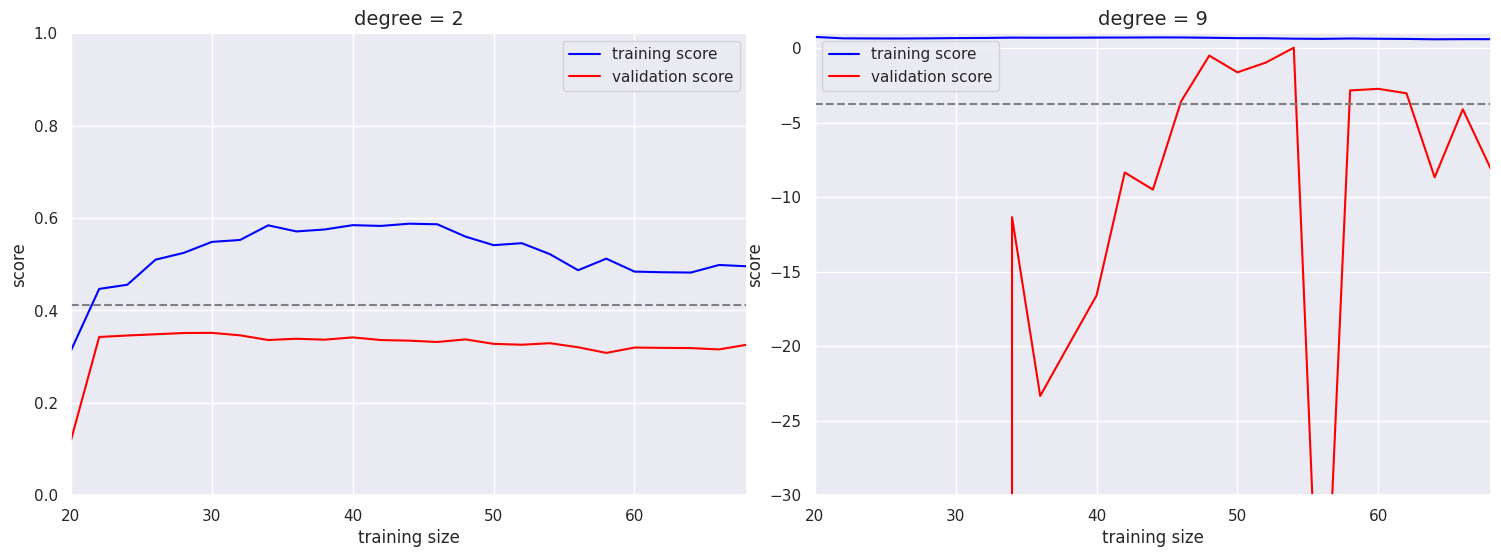

In [22]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    if (i==0):
        ax[i].set_ylim(0, 1)
    if (i==1):
        ax[i].set_ylim(-30, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

This is a valuable diagnostic, because it gives us a visual depiction of how our model responds to increasing training data.
In particular, when your learning curve has already converged (i.e., when the training and validation curves are already close to each other) *adding more training data will not significantly improve the fit!*
This situation is seen in the left panel, with the learning curve for the degree-2 model.

The only way to increase the converged score is to use a different (usually more complicated) model.
We see this in the right panel: by moving to a much more complicated model, we increase the score of convergence (indicated by the dashed line), but at the expense of higher model variance (indicated by the difference between the training and validation scores).
If we were to add even more data points, the learning curve for the more complicated model would eventually converge.

Plotting a learning curve for your particular choice of model and dataset can help you to make this type of decision about how to move forward in improving your analysis.

### 4.2 Hyperparameter Tuning

The preceding discussion is meant to give you some intuition into the trade-off between bias and variance, and its dependence on model complexity and training set size. In practice, models generally have more than one knob to turn, and thus plots of validation and learning curves change from lines to multi-dimensional surfaces. In these cases, such visualizations are difficult, and we would rather simply find the particular model that maximizes the validation score.


In contrast to model parameters which are learned during training, model hyperparameters are set by you ahead of training and control implementation aspects of the model. Hyperparameters can be thought of as model settings. These settings need to be tuned because the ideal settings for one dataset will not be the same across all datasets. When tuning the hyperparameters of a model, Grid Search and Random Search are the two most popular methods. However,  there are more advanced method such as [Evolutionary Algorithms]( https://towardsdatascience.com/hyperparameter-tuning-in-xgboost-using-genetic-algorithm-17bd2e581b17) as well.


#### 4.2.1-Grid Search

Grid Search can be thought of as an exhaustive search for selecting a model’s hyperparameters. In Grid Search,  you need to set up a grid of hyperparameter values and for each combination, trains a model and scores on the validation data. In this approach, every combination of hyperparameter values is tried which can be very inefficient. For example, searching 20 different parameter values for each of 4 parameters will require 160,000 trials of cross-validation. This equates to 1,600,000 model fits and 1,600,000 predictions if 10-fold cross validation is used. While Scikit Learn offers the GridSearchCV function to simplify the process, it would be an extremely costly execution both in computing power and time.


Here is an example of using grid search to find the optimal polynomial model. We will explore a three-dimensional grid of model features; namely the polynomial degree, the flag telling us whether to fit the intercept, and the flag telling us whether to normalize the problem. This can be set up using Scikit-Learn's `GridSearchCV` meta-estimator:


In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree':[1,5,10,15,20],
              'linearregression__fit_intercept': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=10,verbose=1)

Notice that like a normal estimator, this has not yet been applied to any data.
Calling the ``fit()`` method will fit the model at each grid point, keeping track of the scores along the way:

In [24]:
grid.fit(X, y);

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Now that this is fit, we can ask for the best parameters as follows:

In [25]:
grid.best_params_

{'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 1}

Finally, if we wish, we can use the best model and show the fit to our data using code from before:

In [26]:
grid.best_estimator_

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('linearregression', LinearRegression(fit_intercept=False))])

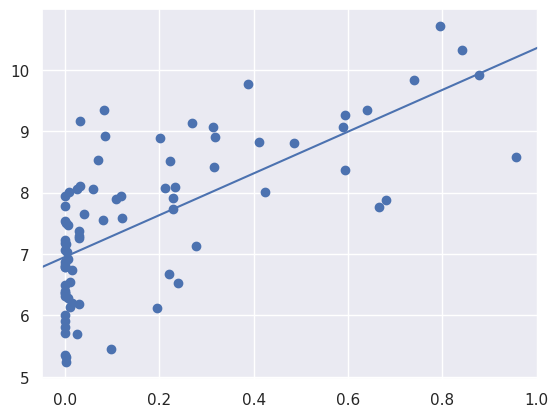

In [27]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

Let's look at the score of each hyperparameter combination tested during the grid search:

In [28]:
import pandas as pd
table=pd.DataFrame(grid.cv_results_)
table

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearregression__fit_intercept,param_polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004891,0.003256,0.001834,0.001710,True,1,"{'linearregression__fit_intercept': True, 'pol...",0.377974,-0.082506,6.758622e-01,0.815818,0.801144,-2.918272e-02,0.086356,0.061556,-0.093954,0.663730,3.276797e-01,3.607734e-01,2
1,0.002869,0.001006,0.001107,0.000681,True,5,"{'linearregression__fit_intercept': True, 'pol...",0.467296,-0.003193,4.520739e-01,0.802273,0.867564,-9.804257e-01,0.333415,-0.100996,-0.115675,0.664818,2.387150e-01,5.279366e-01,3
2,0.003812,0.001390,0.001488,0.000909,True,10,"{'linearregression__fit_intercept': True, 'pol...",0.446502,0.140010,-4.426655e-01,0.562842,0.697971,-4.162088e+02,0.402269,-0.039695,0.212527,0.357247,-4.138718e+01,1.249409e+02,6
3,0.004621,0.002513,0.002451,0.003530,True,15,"{'linearregression__fit_intercept': True, 'pol...",0.163286,0.072204,-4.953576e+00,0.669477,-5.233712,-3.365827e+04,0.319413,-0.160138,0.127650,0.005058,-3.366726e+03,1.009718e+04,8
4,0.006409,0.005299,0.002241,0.003016,True,20,"{'linearregression__fit_intercept': True, 'pol...",-0.027511,-0.045096,-1.151783e+06,0.468159,-7960.814158,-2.118704e+10,0.282262,-0.159182,-13488.619579,-21.459899,-2.118821e+09,6.356072e+09,10
5,0.005753,0.006624,0.001197,0.001166,False,1,"{'linearregression__fit_intercept': False, 'po...",0.377974,-0.082506,6.758622e-01,0.815818,0.801144,-2.918272e-02,0.086356,0.061556,-0.093954,0.663730,3.276797e-01,3.607734e-01,1
6,0.002363,0.001911,0.000792,0.000056,False,5,"{'linearregression__fit_intercept': False, 'po...",0.467296,-0.003193,4.520739e-01,0.802273,0.867564,-9.804257e-01,0.333415,-0.100996,-0.115675,0.664818,2.387150e-01,5.279366e-01,4
7,0.002739,0.002196,0.000803,0.000205,False,10,"{'linearregression__fit_intercept': False, 'po...",0.446502,0.140010,-4.426655e-01,0.562842,0.697971,-4.162088e+02,0.402269,-0.039695,0.212527,0.357247,-4.138718e+01,1.249409e+02,5
8,0.002121,0.001129,0.001487,0.002071,False,15,"{'linearregression__fit_intercept': False, 'po...",0.163285,0.072204,-4.953980e+00,0.669477,-5.233808,-3.365743e+04,0.319413,-0.160138,0.127645,0.005051,-3.366643e+03,1.009693e+04,7
9,0.002078,0.000688,0.001175,0.000640,False,20,"{'linearregression__fit_intercept': False, 'po...",-0.028387,-0.045835,-1.147358e+06,0.468520,-7809.869877,-2.105834e+10,0.282446,-0.159483,-14053.838739,-20.976571,-2.105951e+09,6.317464e+09,9


The Mean and Standard Deviation for the best model was:

In [29]:
best={'param_linearregression__fit_intercept': True,
 'param_polynomialfeatures__degree': 5}
sub_table=table.loc[(table[list(best)] == pd.Series(best)).all(axis=1)]
sub_table[['mean_test_score', 'std_test_score','param_linearregression__fit_intercept',
       'param_polynomialfeatures__degree' ]]

,mean_test_score,std_test_score,param_linearregression__fit_intercept,param_polynomialfeatures__degree
1,0.238715,0.527937,True,5


The grid search provides many more options, including the ability to specify a custom scoring function, to parallelize the computations, to do randomized searches, and more.
For information, refer to Scikit-Learn's [grid search documentation](http://Scikit-Learn.org/stable/modules/grid_search.html).

#### 4.2.2-Random Search


By contrast, Random Search sets up a grid of hyperparameter values and selects random combinations to train the model and score. This allows you to explicitly control the number of parameter combinations that are attempted. The number of search iterations is set based on time or resources. Scikit Learn offers the `RandomizedSearchCV` function for this process.

While it’s possible that `RandomizedSearchCV` will not find as accurate of a result as `GridSearchCV`, it surprisingly picks the best result more often than not and in a fraction of the time it takes `GridSearchCV` would have taken. Given the same resources, Randomized Search can even outperform Grid Search.


In [30]:
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(214)
param_grid = {'polynomialfeatures__degree': np.arange(20),
              'linearregression__fit_intercept': [True, False]}

randCV= RandomizedSearchCV(PolynomialRegression(), param_grid, cv=7)

randCV.fit(X, y);

Now that this is fit, we can ask for the best parameters as follows:

In [31]:
randCV.best_params_

{'polynomialfeatures__degree': 7, 'linearregression__fit_intercept': False}

(4.0, 12.0)

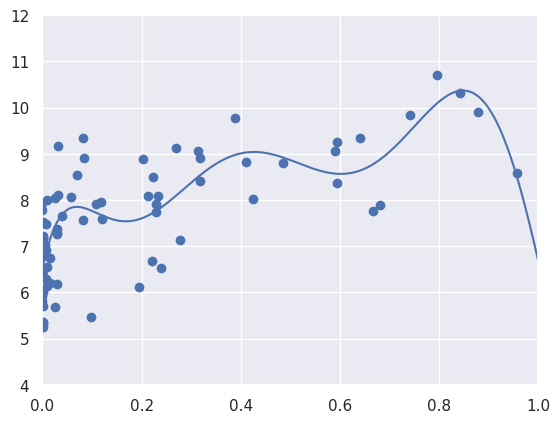

In [32]:
model = randCV.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.xlim(0, 1)
plt.ylim(4, 12)


The Mean and Standard Deviation for the best model was:

In [33]:

table=pd.DataFrame(randCV.cv_results_)
best={'param_linearregression__fit_intercept': randCV.best_params_['linearregression__fit_intercept'],
 'param_polynomialfeatures__degree': randCV.best_params_['polynomialfeatures__degree']}


sub_table=table.loc[(table[list(best)] == pd.Series(best)).all(axis=1)]
sub_table[['mean_test_score', 'std_test_score','param_linearregression__fit_intercept', 'param_polynomialfeatures__degree' ]]

,mean_test_score,std_test_score,param_linearregression__fit_intercept,param_polynomialfeatures__degree
5,0.120518,0.656674,False,7


As you can see, the Random CV approach managed to find a better set of hyperparameters that provided a `mean_test_score`=0.8972, which is greater  than the one from  the Grid Search CV (0.7541). This was because the Grid Search did not tested the hyperparameter `polynomialfeatures__degree`=4

## 5- Hyperparameter Tuning for NN

Let's load, split and scale the MNIST Digits dataset

In [34]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import regularizers
import matplotlib.pyplot as plt
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#load dataset
fashion_mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
#Split and Scale dataset
X_valid, X_train = X_train_full[:5000]/255., X_train_full[5000:]/255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test

11490434/11490434 [==============================] - 2s 0us/step


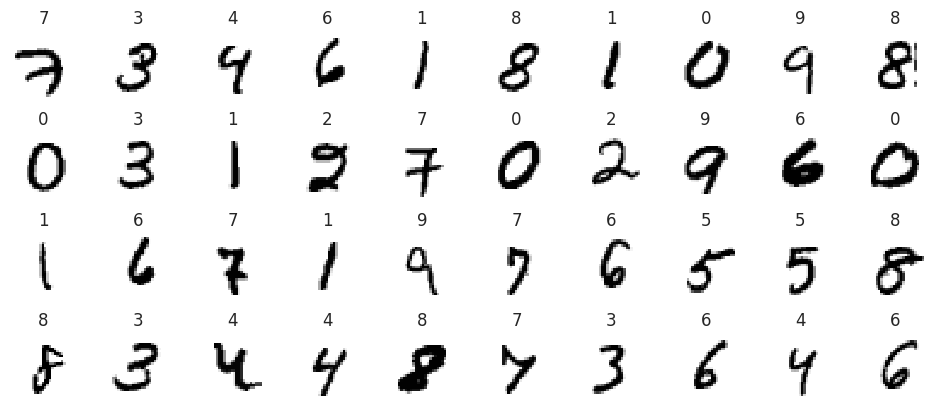

In [35]:
#Here are the corresponding class names:
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

If you want to load the pre-trained model you need run the code below.

In [36]:
#!wget https://raw.githubusercontent.com/lopezbec/intro_python_notebooks/main/grid_model.h5
#!wget https://raw.githubusercontent.com/lopezbec/intro_python_notebooks/main/rnd_model.h5

Lets build a function that allows us to setup a Keras Sequential Model with different hyperparameters

In [50]:
def build_model(n_hidden=1, n_neurons=30, reg=0.001, input_shape=[28, 28]):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu",kernel_regularizer=regularizers.l2(reg)))
    model.add(keras.layers.Dense(10,activation="softmax"))
    optimizer = "sgd"
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics='accuracy')


    return model

keras_reg = keras.wrappers.scikit_learn.KerasClassifier(build_model)

<ipython-input-50-b54c963a4e98>:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasClassifier(build_model)


### 5.1- Grid Search 

In [51]:

np.random.seed(42)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import time

#Lets save the model and use TensorBoard
#Since the hyperparamter tuning process can take several hours, 
#saving the model at each epoch allows us to share the model with other
#and start traning again if something happens (e.g., we used the 12hr of GPU of Google Colab)
checkpoint_cb = keras.callbacks.ModelCheckpoint("grid_model.h5", save_best_only=False)

#Lets read the pre-tranined model if there is any. 
try:  
    model = keras.models.load_model("grid_model.h5") 
    print("Continue Training Model")
    # Do something with the file
except:
    print("Training Model from Scratch")

#What set of Hypeparamater you would like to test
param_distribs = {
    "n_hidden": [1,2,3],
    "n_neurons": [150,200,300],
    "reg":[0.0001, 0.001]
}

#We are using a GridSearchCV
tic = time.process_time()
grid_search_cv = GridSearchCV(keras_reg, param_distribs, cv=3, verbose=1)
history=grid_search_cv.fit(X_train, y_train, epochs=5,batch_size=50,
                   validation_data=(X_valid, y_valid),callbacks=[checkpoint_cb]) 


toc = time.process_time()
time_grid=toc-tic


Continue Training Model
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Epoch 1/5
734/734 [==============================] - 3s 3ms/step - loss: 0.9885 - accuracy: 0.7723 - val_loss: 0.5335 - val_accuracy: 0.8740
Epoch 2/5
734/734 [==============================] - 3s 4ms/step - loss: 0.4759 - accuracy: 0.8825 - val_loss: 0.4088 - val_accuracy: 0.9002
Epoch 3/5
734/734 [==============================] - 2s 3ms/step - loss: 0.4009 - accuracy: 0.8964 - val_loss: 0.3621 - val_accuracy: 0.9114
Epoch 4/5
734/734 [==============================] - 2s 3ms/step - loss: 0.3643 - accuracy: 0.9050 - val_loss: 0.3335 - val_accuracy: 0.9170
Epoch 5/5
573/573 [==============================] - 1s 2ms/step - loss: 0.3420 - accuracy: 0.9094
Epoch 1/5
734/734 [==============================] - 3s 4ms/step - loss: 1.0116 - accuracy: 0.7627 - val_loss: 0.5397 - val_accuracy: 0.8716
Epoch 2/5
734/734 [==============================] - 2s 3ms/step - loss: 0.4745 - accuracy: 0.8816 - val_loss: 

In [52]:

#lets look at the best model found
grid_search_cv.best_params_


{'n_hidden': 3, 'n_neurons': 300, 'reg': 0.0001}

In [53]:
#Load saved model, just in case someting happens while training
model_grid = keras.models.load_model("grid_model.h5") 
model_grid.summary()

Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_110 (Flatten)       (None, 784)               0         
                                                                 
 dense_322 (Dense)           (None, 300)               235500    
                                                                 
 dense_323 (Dense)           (None, 300)               90300     
                                                                 
 dense_324 (Dense)           (None, 300)               90300     
                                                                 
 dense_325 (Dense)           (None, 10)                3010      
                                                                 
Total params: 419,110
Trainable params: 419,110
Non-trainable params: 0
_________________________________________________________________


In [54]:
train_grid=model_grid.evaluate(X_train, y_train, verbose=0)
valid_grid=model_grid.evaluate(X_valid, y_valid, verbose=0)
test_grid=model_grid.evaluate(X_test, y_test, verbose=0)

print("Time to train the model: {0:.4f} secs ".format((time_grid)))
print("Training Set Accuracy:   {0:.4%} & Loss:{1:.4f}".format(train_grid[1],train_grid[0]))
print("Validation Set Accuracy: {0:.4%} & Loss:{1:.4f}".format(valid_grid[1],valid_grid[0]))
print("Test Set Accuracy:       {0:.4%} & Loss:{1:.4f}".format(test_grid[1],test_grid[0]))

Time to train the model: 1016.1053 secs 
Training Set Accuracy:   94.9000% & Loss:0.2817
Validation Set Accuracy: 95.0800% & Loss:0.2760
Test Set Accuracy:       94.7400% & Loss:23.7120


### 5.2-  Random Search 

In [55]:

np.random.seed(42)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import time

#Lets save the model and use TensorBoard
#Since the hyperparamter tuning process can take several hours, 
#saving the model at each epoch allows us to share the model with other
#and start traning again if something happens (e.g., we used the 12hr of GPU of Google Colab)
checkpoint_cb = keras.callbacks.ModelCheckpoint("rnd_model.h5", save_best_only=False)

#Lets read the pre-tranined model if there is any. 
try:  
    model = keras.models.load_model("rnd_model.h5") 
    print("Continue Training Model")
    # Do something with the file
except:
    print("Training Model from Scratch")

#What set of Hypeparamater you would like to test
param_distribs = {
    "n_hidden": [1,2,3],
    "n_neurons": [150,200,300],
    "reg":[0.0001, 0.001]
}

#We are using a GridSearchCV
tic = time.process_time()


rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, cv=3, verbose=1)
history=rnd_search_cv.fit(X_train, y_train, epochs=5,batch_size=50,
                  validation_data=(X_valid, y_valid),callbacks=[checkpoint_cb]) 




toc = time.process_time()
time_rnd=toc-tic



Continue Training Model
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/5
734/734 [==============================] - 3s 3ms/step - loss: 0.9880 - accuracy: 0.7685 - val_loss: 0.5366 - val_accuracy: 0.8762
Epoch 2/5
734/734 [==============================] - 2s 3ms/step - loss: 0.4752 - accuracy: 0.8816 - val_loss: 0.4092 - val_accuracy: 0.9026
Epoch 3/5
734/734 [==============================] - 2s 3ms/step - loss: 0.3969 - accuracy: 0.8985 - val_loss: 0.3605 - val_accuracy: 0.9108
Epoch 4/5
734/734 [==============================] - 2s 3ms/step - loss: 0.3593 - accuracy: 0.9078 - val_loss: 0.3314 - val_accuracy: 0.9172
Epoch 5/5
573/573 [==============================] - 1s 2ms/step - loss: 0.3374 - accuracy: 0.9131
Epoch 1/5
734/734 [==============================] - 3s 3ms/step - loss: 1.0014 - accuracy: 0.7683 - val_loss: 0.5481 - val_accuracy: 0.8696
Epoch 2/5
734/734 [==============================] - 2s 3ms/step - loss: 0.4826 - accuracy: 0.8782 - val_loss: 

In [56]:

#lets look at the best model found
rnd_search_cv.best_params_


{'reg': 0.0001, 'n_neurons': 300, 'n_hidden': 3}

In [57]:
#Load saved model, just in case someting happens while training
model_rnd = keras.models.load_model("rnd_model.h5") 
model_rnd.summary()

Model: "sequential_141"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_141 (Flatten)       (None, 784)               0         
                                                                 
 dense_410 (Dense)           (None, 300)               235500    
                                                                 
 dense_411 (Dense)           (None, 300)               90300     
                                                                 
 dense_412 (Dense)           (None, 300)               90300     
                                                                 
 dense_413 (Dense)           (None, 10)                3010      
                                                                 
Total params: 419,110
Trainable params: 419,110
Non-trainable params: 0
_________________________________________________________________


In [58]:
train_rnd=model_rnd.evaluate(X_train, y_train, verbose=0)
valid_rnd=model_rnd.evaluate(X_valid, y_valid, verbose=0)
test_rnd=model_rnd.evaluate(X_test, y_test, verbose=0)

print("Time to train the model: {0:.4f} secs ".format((time_rnd)))
print("Training Set Accuracy:   {0:.4%} & Loss:{1:.4f}".format(train_rnd[1],train_rnd[0]))
print("Validation Set Accuracy: {0:.4%} & Loss:{1:.4f}".format(valid_rnd[1],valid_rnd[0]))
print("Test Set Accuracy:       {0:.4%} & Loss:{1:.4f}".format(test_rnd[1],test_rnd[0]))

Time to train the model: 557.6545 secs 
Training Set Accuracy:   95.1273% & Loss:0.2758
Validation Set Accuracy: 95.1800% & Loss:0.2712
Test Set Accuracy:       94.6200% & Loss:24.3035


Lets compare the models

In [59]:
#model_rnd.summary()
print(rnd_search_cv.best_params_)
print("Time to train the model: {0:.4f} secs ".format((time_rnd)))
print("Training Set Accuracy:   {0:.4%} & Loss:{1:.4f}".format(train_rnd[1],train_rnd[0]))
print("Validation Set Accuracy: {0:.4%} & Loss:{1:.4f}".format(valid_rnd[1],valid_rnd[0]))
print("Test Set Accuracy:       {0:.4%} & Loss:{1:.4f}".format(test_rnd[1],test_rnd[0]))

{'reg': 0.0001, 'n_neurons': 300, 'n_hidden': 3}
Time to train the model: 557.6545 secs 
Training Set Accuracy:   95.1273% & Loss:0.2758
Validation Set Accuracy: 95.1800% & Loss:0.2712
Test Set Accuracy:       94.6200% & Loss:24.3035


In [60]:
#model_grid.summary()
print(grid_search_cv.best_params_)
print("Time to train the model: {0:.4f} secs ".format((time_grid)))
print("Training Set Accuracy:   {0:.4%} & Loss:{1:.4f}".format(train_grid[1],train_grid[0]))
print("Validation Set Accuracy: {0:.4%} & Loss:{1:.4f}".format(valid_grid[1],valid_grid[0]))
print("Test Set Accuracy:       {0:.4%} & Loss:{1:.4f}".format(test_grid[1],test_grid[0]))

{'n_hidden': 3, 'n_neurons': 300, 'reg': 0.0001}
Time to train the model: 1016.1053 secs 
Training Set Accuracy:   94.9000% & Loss:0.2817
Validation Set Accuracy: 95.0800% & Loss:0.2760
Test Set Accuracy:       94.7400% & Loss:23.7120
